# Redundant Calibration Nightly Data Quality Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from hera_cal import io, redcal, apply_cal
from hera_qm.metrics_io import load_metric_file
import glob
import os
from copy import deepcopy
import inspect
import h5py

%matplotlib inline

In [2]:
# Use environment variables to figure out path to data
JD = os.environ['JULIANDATE']
data_path = os.environ['DATA_PATH']
print('Looking for data in', data_path, 'on JD', JD)

data_list = sorted(glob.glob(os.path.join(data_path, 'zen.{}.?????.sum.uvh5'.format(JD))))
if len(data_list) == 0:
    data_list = sorted(glob.glob(os.path.join(data_path, 'zen.{}.?????.uvh5'.format(JD))))
print('Found {} files.'.format(len(data_list)))

Looking for data in /mnt/sn1 on JD 2458931
Found 1862 files.


# Load Single File

In [3]:
# Pick middle of the night data file to examine
example_file = data_list[len(data_list)//2]
file_JD = '.'.join([s for s in example_file.split('.') if s.isdigit()])

In [4]:
# controls how many redundant baseline groups to plot. 
# 2 means the most common ee- and nn-polarized baseline.
n_reds_to_plot = 2  

In [5]:
# Load omnical gains and determine ex_ants
hc = io.HERACal(example_file.replace('.uvh5', '.omni.calfits'))
gains, gain_flags, _, _ = hc.read()
ex_ants = [ant for ant in gain_flags if np.all(gain_flags[ant])]

# Load the most common redundant baselines and calibrate
hd = io.HERAData(example_file)
reds = redcal.get_reds(hd.antpos, pols=['ee', 'nn'])
red_bl_map = {bl: red[0] for red in reds for bl in red} 
reds = redcal.filter_reds(reds, ex_ants=ex_ants)
reds = sorted(reds, key=len, reverse=True)
data, flags, nsamples = hd.read(
    bls=[bl for red in reds[0:n_reds_to_plot] for bl in red])
apply_cal.calibrate_in_place(data, gains, data_flags=flags, cal_flags=gain_flags)

# Load omnical visibility solutions
hdo = io.HERAData(example_file.replace('.uvh5', '.omni_vis.uvh5'))
omni_data, omni_flags, omni_nsamples = hdo.read(
    bls=[red_bl_map[red[0]] for red in reds[0:n_reds_to_plot]])

# Inspect Single File

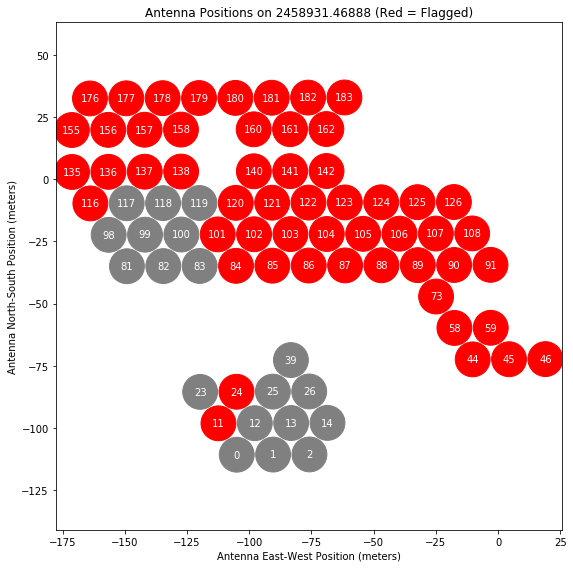

In [6]:
plt.figure(figsize=(8,8))
plt.scatter(np.array(list(hd.antpos.values()))[:,0], 
            np.array(list(hd.antpos.values()))[:,1], c='w', s=0)
for ant,pos in hd.antpos.items():
    bad = ant in [ant[0] for ant in ex_ants]
    plt.gca().add_artist(plt.Circle(tuple(pos[0:2]), radius=7, 
                                    fill=(~bad), color=['grey','r'][bad]))
    plt.text(pos[0],pos[1],str(ant), va='center', ha='center', color='w')
plt.xlabel("Antenna East-West Position (meters)")
plt.ylabel("Antenna North-South Position (meters)")
plt.title('Antenna Positions on {} (Red = Flagged)'.format(file_JD));
plt.axis('equal')
plt.tight_layout()
plt.show()

### Figure 1: Array and Flagged Antennas

#### OBSERVER CHECKLIST:
* Check that the array configuration looks reasonable.
* Check that all flags expected to be flagged are actually flagged but also that not everything is getting flagged.

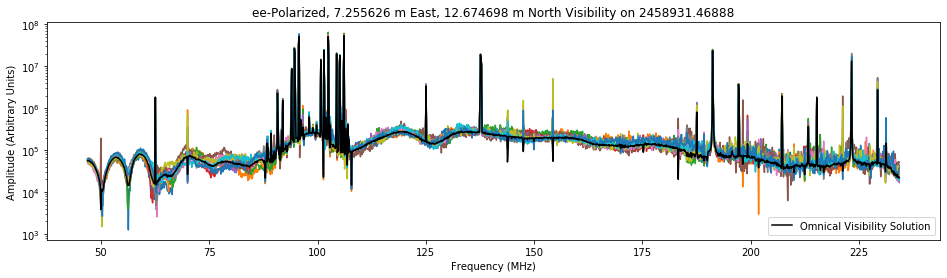

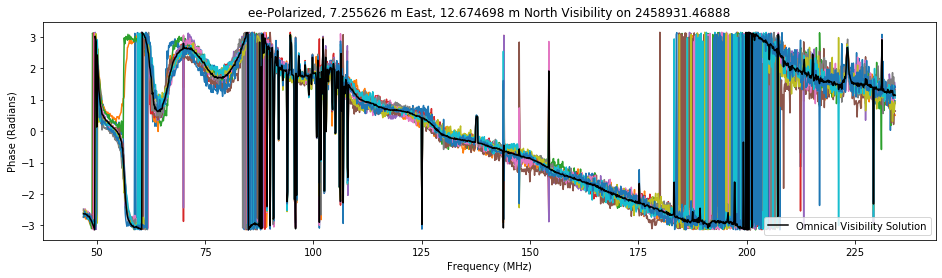

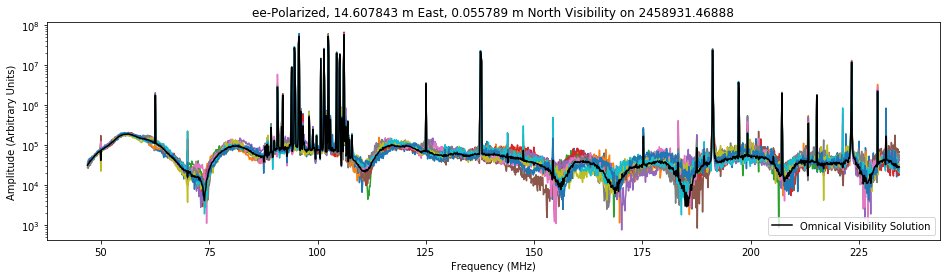

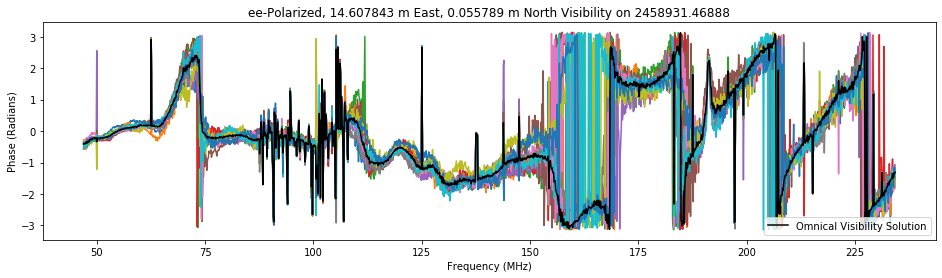

In [7]:
# Plot redundant groups
for red in reds[0:n_reds_to_plot]:
    blvec = hd.antpos[red[0][1]] - hd.antpos[red[0][0]]
    for func, plot, ylabel in zip([np.abs, np.angle], [plt.semilogy, plt.plot], ['Amplitude (Arbitrary Units)', 'Phase (Radians)']):
        plt.figure(figsize=(16,4))
        for bl in red:
            plot(hd.freqs/1e6, func(np.median(data[bl], axis=0)))
        plot(hd.freqs/1e6, func(np.median(omni_data[red_bl_map[red[0]]], axis=0)), 'k-', label='Omnical Visibility Solution')
        plt.xlabel('Frequency (MHz)')
        plt.ylabel(ylabel)
        plt.legend(loc='lower right')
        plt.title('{}-Polarized, {:f} m East, {:f} m North Visibility on {}'.format(red[0][2], blvec[0], blvec[1], file_JD))

### Figure 2: Example redundant baseline groups and omnical visibility solution for a single file.


#### OBSERVER CHECKLIST:
* Check that that there actually is something plotted and the data isn't all flagged somehow.
* Check whether most of the baselines cluster together and that the black line follows the cluster.
* Check whether there are any significant outliers (though it won't be clear as yet which antennas those are attributable to, see below).

# Load Whole Day

In [8]:
# load all redcal metadata into dictionaries 
meta_list = [df.replace('.uvh5', '.redcal_meta.hdf5') for df in data_list]
ee_iters_dict = {}
nn_iters_dict = {}
dlys_dict = {}
flips_dict = {}
times_dict = {}
lsts_dict = {}
histories_dict = {}
ants = set([])
for mf in meta_list:
    (fc_meta, omni_meta, freqs, times_dict[mf], lsts_dict[mf], 
     antpos, histories_dict[mf]) = io.read_redcal_meta(mf)
    ee_iters_dict[mf] = omni_meta['iter']["['ee']"]
    nn_iters_dict[mf] = omni_meta['iter']["['nn']"]
    flips_dict[mf] = fc_meta['polarity_flips']
    dlys_dict[mf] = fc_meta['dlys']
    ants |= set(fc_meta['dlys'].keys())
    
ants = sorted(ants)
times = np.array(list(times_dict.values())).flatten()
lsts = np.array(list(lsts_dict.values())).flatten()

OSError: Unable to open file (unable to open file: name = '/mnt/sn1/zen.2458931.26062.sum.redcal_meta.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [9]:
# Load aprior statuses from histories
apriori_exants = {}
for mf in histories_dict:
    ex_ants_string = histories_dict[mf].split('--ex_ants')[1].split('--')[0].strip()
    apriori_exants[mf] = [int(ant) for ant in ex_ants_string.split()]

In [10]:
# Load xants from ant metrics
ant_metrics_list = [df.replace('.uvh5', '.ant_metrics.hdf5') for df in data_list]
am_xants_dict = {}
for amf in ant_metrics_list:
    with h5py.File(amf, "r") as infile:
        xants = infile['Metrics']['xants'][:]    
    am_xants_dict[amf] = [(int(ant[0]), ant[1].tostring().decode('utf8').replace('n',
                          'Jnn').replace('e', 'Jee')) for ant in xants]

OSError: Unable to open file (unable to open file: name = '/mnt/sn1/zen.2458931.67692.sum.ant_metrics.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [11]:
# Load chisq and flagging info from omnical gains
cal_list = [df.replace('.uvh5', '.omni.calfits') for df in data_list]
ant_flags_dict = {}
chisq_ee_dict = {}
chisq_nn_dict = {}
cspa_med_dict = {}

for cal in cal_list:
    hc = io.HERACal(cal)
    _, flags, cspa, chisq = hc.read()
    
    ant_flags_dict[cal] = {ant: np.all(flags[ant]) for ant in flags}
    chisq_ee_dict[cal] = chisq['Jee']
    chisq_nn_dict[cal] = chisq['Jnn']
    cspa_med_dict[cal] = {ant: np.nanmedian(cspa[ant], axis=1) for ant in cspa}

cspa = {ant: np.hstack([np.squeeze(cspa_med_dict[cal][ant]) / \
                        ~ant_flags_dict[cal][ant] for cal in cal_list]) for ant in ants}

AssertionError: /mnt/sn1/zen.2458931.26062.sum.omni.calfits does not exist.

In [12]:
# save lowest-numbered ants with a minimal number of flags
ants_to_save = {}
for pol in ['Jee', 'Jnn']:
    min_flags = np.min([np.sum(~np.isfinite(cspa[ant])) 
                        for ant in cspa if ant[1] == pol])
    ants_to_save[pol] = sorted([ant for ant in cspa 
                                if np.sum(~np.isfinite(cspa[ant])) == min_flags 
                                and ant[1] == pol])[0:2]

# Reload omnical gains
gain_dict = {}
for cal in cal_list:
    hc = io.HERACal(cal)
    gains, _, _, _ = hc.read()
    gain_dict[cal] = {ant: gains[ant] for pol in ants_to_save 
                      for ant in ants_to_save[pol]}

gains = {ant: np.vstack([gain_dict[cal][ant] for cal in gain_dict]) 
         for pol in ants_to_save for ant in ants_to_save[pol]}    

NameError: name 'cspa' is not defined

# Inspect Whole Day

In [13]:
# Build up exants grid
exants_grid = np.zeros((len(ants),len(cal_list)))

# 0 = no flags, 1 = apriori, 2 = ant metrics, 3 = omnical
for f, cal in enumerate(ant_flags_dict):
    for i, ant in enumerate(ants):
        exants_grid[i, f] = 3.0 * np.float(ant_flags_dict[cal][ant])
for f, amf in enumerate(am_xants_dict):
    for i, ant in enumerate(ants):
        if ant in am_xants_dict[amf]:
            exants_grid[i, f] = 2.0                
for f, mf in enumerate(apriori_exants):
    for i, ant in enumerate(ants):
        if ant[0] in apriori_exants[mf]:
            exants_grid[i, f] = 1.0

from mpl_toolkits.axes_grid1 import make_axes_locatable
color_order = ['black', 'gold', 'magenta', 'cyan']
cmap = matplotlib.colors.ListedColormap(color_order)
bounds=np.arange(len(color_order)+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
            
fig = plt.figure(figsize=(14,len(ants)/4.625))
im = plt.imshow(exants_grid, aspect='auto', cmap=cmap, norm=norm,
                extent=[lsts[0]*12/np.pi, lsts[-1]*12/np.pi, len(ants), 0])
plt.yticks(np.arange(len(ants))+.5, 
           labels = ['{}{}'.format(ant[0], ant[1][-1]) for ant in ants]);
plt.grid(color='w', linestyle='-', linewidth=1.5, axis='y')
plt.xlabel('LST (Hours)')

divider = make_axes_locatable(plt.gca())
cax = divider.new_vertical(size=.4, pad=0.5, pack_start=False)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_ticks(.5 + np.arange(len(color_order)))
cbar.set_ticklabels(['No Flags', 'Flagged A Priori', 
                     'Flagged by Ant Metrics', 'Flagged by Redcal'])

NameError: name 'lsts' is not defined

<Figure size 1008x0 with 0 Axes>

### Figure 3: Antenna Flagging
Shows progressive stages of flagging.


#### OBSERVER CHECKLIST:
* Check for new antennas that went bad but weren't in the a priori list. If these are consistently flagged, mark the antenna as "calibration triage"

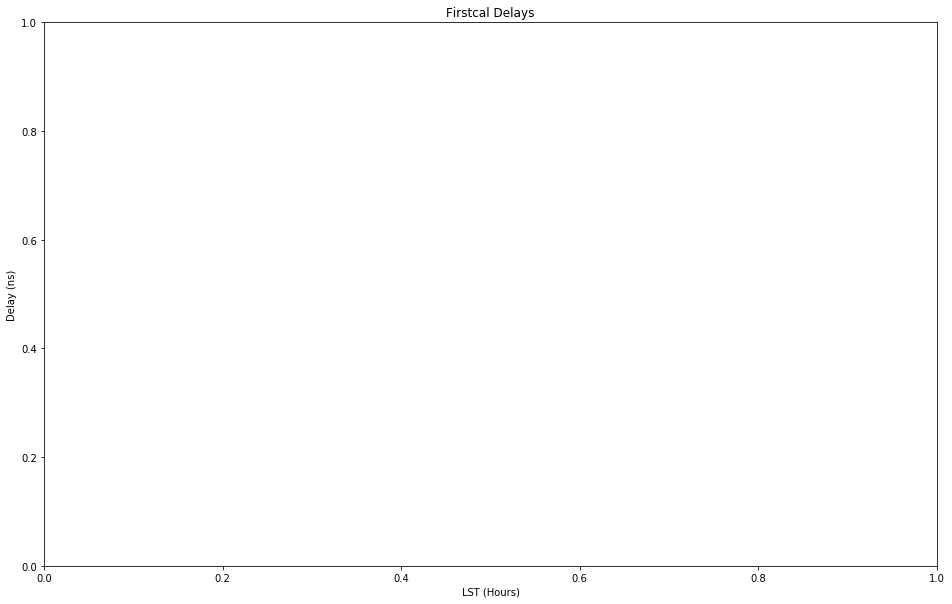

In [14]:
# Plot delays
dlys = {ant: np.hstack([dlys_dict[mf][ant] for mf in dlys_dict]) for ant in ants}
dly_meds = {ant: np.nanmedian(dlys[ant]) for ant in dlys}
plt.figure(figsize=(16,10))
for ant in dlys:
    plt.plot(lsts*12/np.pi, (dlys[ant])*1e9)
    if np.isfinite(dly_meds[ant]):
        plt.text(12/np.pi * (np.min(lsts) - 20*np.median(np.diff(lsts))), 
                 1e9*dly_meds[ant], '{}{}'.format(ant[0], ant[1][-1]), 
                 va='center', ha='right', fontsize=8)    

plt.xlabel('LST (Hours)')
plt.ylabel('Delay (ns)')
plt.title('Firstcal Delays');

### Figure 4: Firstcal Delays
Shows solved firstcal delays. These will have an arbitrary tip/tilt and offset.


#### OBSERVER CHECKLIST:
* Look for outliers. All antennas should be within a few hundred ns. 

In [15]:
# Plot offset delays
plt.figure(figsize=(16, len(ants)/7.4))
for n, ant in enumerate(dlys):
    plt.plot(lsts*12/np.pi, (dlys[ant]-dly_meds[ant])*1e9 + n, label=ant)
    plt.text(12/np.pi * (np.min(lsts) - 20*np.median(np.diff(lsts))), 
             n, '{}{}'.format(ant[0], ant[1][-1]), 
             va='center', ha='right', fontsize=8)
# plt.legend(ncol=3)
plt.xlabel('LST (Hours)')
plt.ylabel('Delay with Arbitrary Offset (ns)')
plt.title('Firstcal Delays With Arbitrary Offset');

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

### Figure 5: Offset Firstcal Delays
Same as Figure 4, but with arbitrary offsets for each antenna.


#### OBSERVER CHECKLIST:
* Look for antennas that exhibit wild swings (> 10 ns) in their delay over time, especially discontinuities that cannot be attributed to inconsistent antenna flagging (see Figure 3).

In [16]:
# Figure out oc_maxiter
if np.all(['oc_maxiter' in history for history in histories_dict.values()]):
    history = list(histories_dict.values())[0]
    oc_maxiter = int(history.split('--oc_maxiter')[1].split('--')[0])
else:
    oc_maxiter = inspect.signature(redcal.redcal_run).parameters['oc_maxiter'].default

IndexError: list index out of range

In [17]:
# Recast from dictionaries to one big array
ee_iters = np.vstack(np.array(list(ee_iters_dict.values())))
nn_iters = np.vstack(np.array(list(nn_iters_dict.values())))
plt.figure(figsize=(20,12))

my_cmap = deepcopy(matplotlib.cm.get_cmap('viridis'))
my_cmap.set_under('w')
my_cmap.set_over('r')

for sp, iters, t in zip([121, 122], [ee_iters, nn_iters], 
                        ['ee-polarized', 'nn-polarized']):
    plt.subplot(sp)
    plt.imshow(iters, aspect='auto', cmap=my_cmap, vmin=1, vmax=oc_maxiter-1,
               extent=[freqs[0]/1e6, freqs[-1]/1e6, 
                       lsts[-1]*12/np.pi, lsts[0]*12/np.pi])
    plt.title('Number of Omnical Iterations: ' + t)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('LST (Hours)')    
    plt.colorbar()

ValueError: need at least one array to concatenate

### Figure 6: Number of omnical iterations per polarization
Red indicates that omnical reached the maximum number of integrations. White indicates that omnical didn't run, likely because the data were flagged.


#### OBSERVER CHECKLIST:
* Check that few-to-no data were flagged (white) before omnical and check that this matches
* Check that few-to-no data hit the maximum number of iterations for omnical (red)

KeyError: (86, 'Jee')

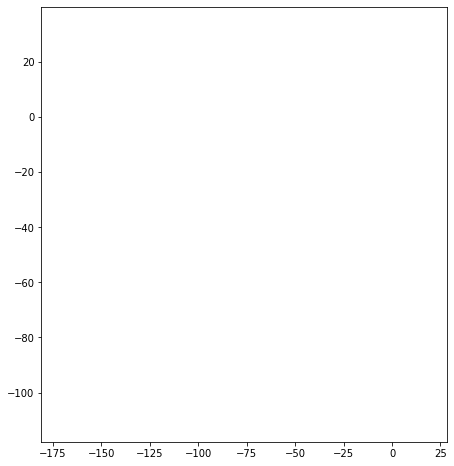

In [18]:
# Make dictionary mapping antenna to the whole night of antenna flips
flips = {ant: np.hstack([flips_dict[mf][ant] for mf in flips_dict]) for ant in ants}

plt.figure(figsize=(16,8))
my_cmap = matplotlib.cm.get_cmap('cool')
for sp, jpol, t in zip([121, 122], ['Jee', 'Jnn'], ['ee-polarized ', 'nn-polarized']):
    plt.subplot(sp)
    plt.scatter(np.array(list(hd.antpos.values()))[:,0], 
                np.array(list(hd.antpos.values()))[:,1],
                c='w', s=0)
    for ant,pos in hd.antpos.items():
        flip_frac = np.nanmean(flips[(ant, jpol)])
        if np.isfinite(flip_frac):
            color=my_cmap(flip_frac)
        else:
            color='w'
        plt.gca().add_artist(plt.Circle(tuple(pos[0:2]), radius=7, 
                                        fill=(~bad), color=color, ec='k'))
        plt.text(pos[0], pos[1],
                 '{}:\n{}%'.format(ant, np.round(100*flip_frac,0)), 
                 va='center', ha='center', color='k')
    plt.xlabel("Antenna East-West Position (meters)")
    plt.ylabel("Antenna North-South Position (meters)")
    
    # count the number of times a self-consistent polarity flip solution was found
    all_flips_this_pol = [flips[ant] for ant in flips if ant[1] == jpol]
    success = np.round(100*np.mean(np.any(np.isfinite(all_flips_this_pol), axis=0)), 2)
    plt.title(t + ' Polarity Flips -- Solution Found {}% of the Time'.format(success))
    plt.axis('equal')
    plt.tight_layout()

### Figure 7: Detection of polarity-flipped antennas
Blue indicates nominal operation, pink indicates polarity flips. 


#### OBSERVER CHECKLIST:
* Check that all antennas are either nearly 100% flipped, nearly 0% flipped, or flagged.
* Check that a solution for polarity flips was found a reasonable percentage of the time (ideally more than a few %)

In [19]:
# Grid and plot overall chi^2 for each polarization
ee_chisq = np.vstack(np.array(list(chisq_ee_dict.values())))
nn_chisq = np.vstack(np.array(list(chisq_nn_dict.values())))
plt.figure(figsize=(20,12))

for sp, cs, t in zip([121, 122], [ee_chisq, nn_chisq], ['ee-polarized', 'nn-polarized']):
    plt.subplot(sp)
    plt.imshow(cs, aspect='auto', vmin=1, cmap='inferno', vmax=5,
               extent=[freqs[0]/1e6, freqs[-1]/1e6, lsts[-1]*12/np.pi, lsts[0]*12/np.pi])
    plt.title('Overall $\chi^2$ / DoF: ' + t)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('LST (Hours)')        
    plt.colorbar()
    

ValueError: need at least one array to concatenate

### Figure 8: Overall $\chi^2$ / DoF


#### OBSERVER CHECKLIST:
* Looks for regions of large non-redundancy not directly attributable to RFI.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


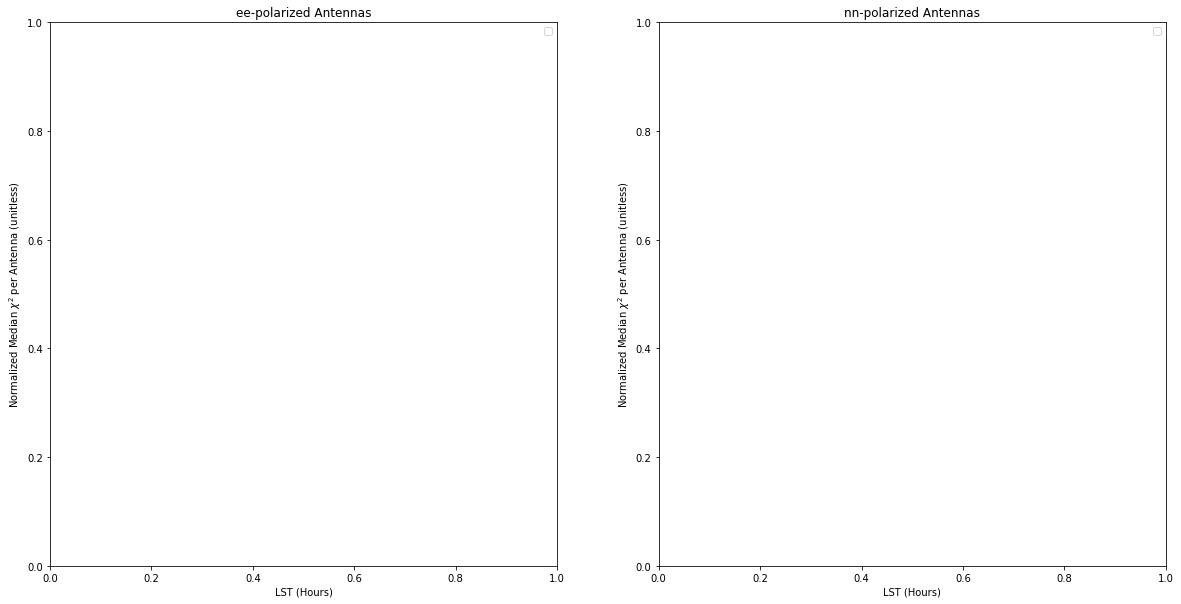

In [20]:
# plot all chi^2 per antenna, highlight antennas that get flagged but not always
plt.figure(figsize=(20,10))
for sp, pol, t in zip([121, 122], ['Jee', 'Jnn'], ['ee-polarized', 'nn-polarized']):
    plt.subplot(sp)
    for ant in ants:
        if ant[1] == pol:
            if not np.all([ant_flags_dict[cal][ant] for cal in cal_list]):
                if np.any([ant_flags_dict[cal][ant] and 
                           not np.all(list(ant_flags_dict[cal].values())) 
                           for cal in cal_list]):
                    plt.plot(lsts*12/np.pi, cspa[ant], '.', label=ant)
                else:
                    plt.plot(lsts*12/np.pi, cspa[ant], '-', c='grey', alpha=.5, lw=.25)
    plt.ylabel('Normalized Median $\chi^2$ per Antenna (unitless)')
    plt.xlabel('LST (Hours)')
    plt.title(t + ' Antennas')
    plt.legend()

### Figure 9: Normalized $\chi^2$ per antenna
Only unflagged data is shown, but antennas that were ever flagged are colored and shown in the legend. All other antennas are shown in grey.

#### OBSERVER CHECKLIST:
* Look for outliers in the chi^2 per antenna distribution
* Look for evidence that antenna that was sometimes flagged should have been always flagged. 

KeyError: 'Jee'

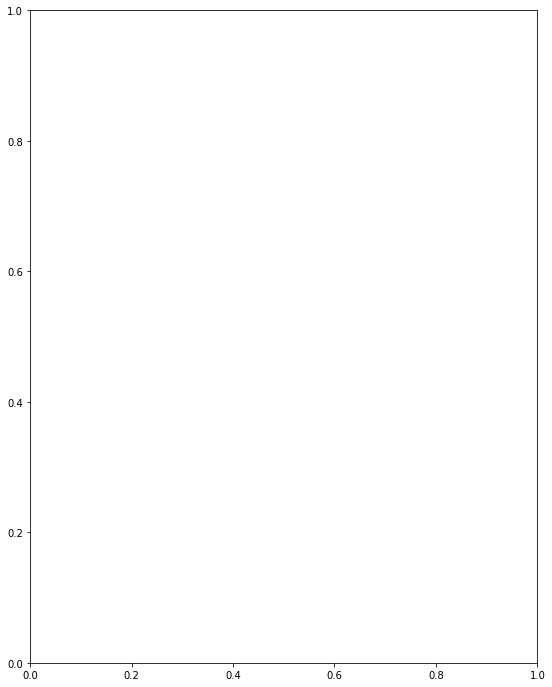

In [21]:
# Plot example gain amplitudes
plt.figure(figsize=(20,12))
for sp, pol in zip([121, 122], ['Jee', 'Jnn']):
    plt.subplot(sp)
    ant = ants_to_save[pol][1]
    plt.title(str(ant) + ' Gain Magnitude')
    plt.imshow(np.abs(gains[ant]), aspect='auto', cmap='inferno',
               extent=[freqs[0]/1e6, freqs[-1]/1e6, lsts[-1]*12/np.pi, lsts[0]*12/np.pi])
    plt.clim([0,2])
    plt.colorbar()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('LST (Hours)')        

### Figure 10: Example Amplitudes


#### OBSERVER CHECKLIST:
* Looks for large discontinuities or fuzziness not attributable to RFI

KeyError: 'Jee'

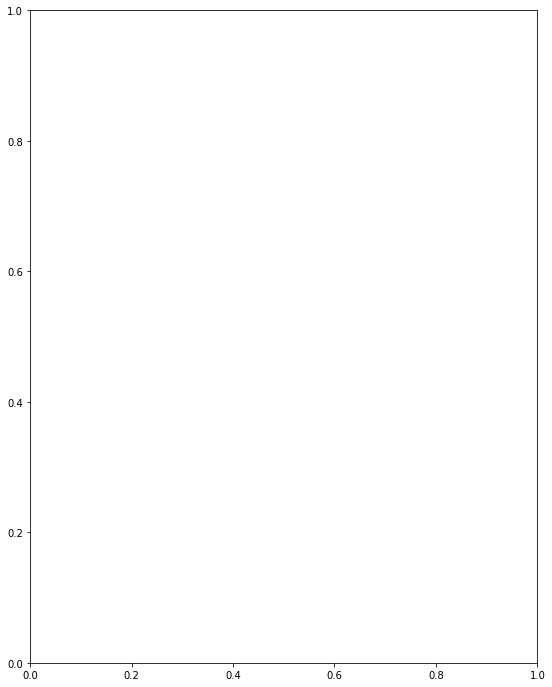

In [22]:
# Plot example gain relative phases
plt.figure(figsize=(20,12))
for sp, pol in zip([121, 122], ['Jee', 'Jnn']):
    plt.subplot(sp)
    ant0, ant1 = ants_to_save[pol]
    plt.title('Angle of gains[{}] / gains[{}]'.format(ant0, ant1))
    plt.imshow(np.angle(gains[ant0] / gains[ant1]), aspect='auto', cmap='twilight',
               extent=[freqs[0]/1e6, freqs[-1]/1e6, lsts[-1]*12/np.pi, lsts[0]*12/np.pi])
    plt.colorbar()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('LST (Hours)')        

### Figure 11: Example Gain Phases
Relative gain phases of two example antennas.

#### OBSERVER CHECKLIST:
* Check that these gains are relatively stable in time and that there aren't huge phase discontinuities.

# Metadata

In [23]:
print(redcal.version.history_string())


------------
This file was produced by the function <module>() in <ipython-input-23-c6de44361328> using: 
    git_branch: master
    git_description: v3.0-272-gc704901
    git_hash: c704901d45104e8d61f5015afac5f222bf36cdcf
    git_origin: https://github.com/HERA-Team/hera_cal.git
    version: 3.0
------------

